In [2]:
from Bio.PDB import PDBParser
import numpy as np
import os
from Bio.PDB import Residue
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [4]:
path = "resources/5jxv.pdb"
parser = PDBParser()
chain = parser.get_structure(os.path.basename(path), path).get_models().__next__().get_chains().__next__()

In [5]:
def dist(point1: np.array, point2: np.array) -> float:
    squared_sum = float(0)
    for i in range(len(point1)):
        squared_sum += np.power((point1[i] - point2[i]), 2)
    return np.sqrt(squared_sum)

In [6]:
def residue_to_dict(residue: Residue) -> dict:
    atoms = {}
    for atom in residue.get_atoms():
        atoms[atom.get_id()] = np.array(atom.get_coord())
    return atoms

In [7]:
def dssp(acceptor: Residue, donor: Residue) -> float:
    # extracting atoms and positions:
    at_donor = residue_to_dict(donor)
    at_acceptor = residue_to_dict(acceptor)

    # checking if all necessary atoms are present:
    if not "N" in at_donor.keys() or\
            not "H" in at_donor.keys() or\
            not "C" in at_acceptor.keys() or\
            not "O" in at_acceptor.keys():
        return np.nan

    # calculating distances:
    rON = dist(at_acceptor["O"], at_donor["N"])
    rCH = dist(at_acceptor["C"], at_donor["H"])
    rOH = dist(at_acceptor["O"], at_donor["H"])
    rCN = dist(at_acceptor["C"], at_donor["N"])

    # calculating energy:
    # 0.084: partial charges
    # 332: factor from paper
    # 4.184: kcal -> kj
    # result in kj/mol (paper)
    return 0.084*(1/rON + 1/rCH - 1/rOH - 1/rCN)*332*4.184

In [8]:
# iterating over all pairs of residues:
# initialize matrix E with zeroes
E = np.array([[float(0) for i in range(len(chain))] for j in range(len(chain))])
# array with residues:
residues = [residue for residue in chain.get_residues()]
for i in range(len(residues)):
    for j in range(len(residues)):
        E[i][j] = dssp(residues[i], residues[j])
E

array([[-6.49027583e+00, -1.50358183e+01, -1.39423363e+00, ...,
         1.55045495e-02, -8.29838320e-03,  7.83731584e-03],
       [ 1.33648402e-01, -6.48670683e+00, -1.50601346e+01, ...,
        -7.29798687e-03,  1.70257760e-03, -6.58367556e-03],
       [-5.88795074e-02,  1.29671116e-01, -6.15638794e+00, ...,
        -1.41133249e-02,  1.61737828e-02, -9.19484141e-04],
       ...,
       [ 4.14189457e-03, -8.42449391e-03,  2.18415681e-03, ...,
        -6.93886320e+00, -1.49983187e+01, -1.59092533e+00],
       [-3.25787915e-03,  6.30188329e-03, -9.00986761e-03, ...,
         3.92303228e-01, -6.78169780e+00, -1.50625461e+01],
       [-7.39333125e-03, -1.66082895e-03, -3.77115723e-03, ...,
         2.98470272e-02, -5.48193617e-01, -1.91351075e+00]])

<Figure size 432x288 with 0 Axes>

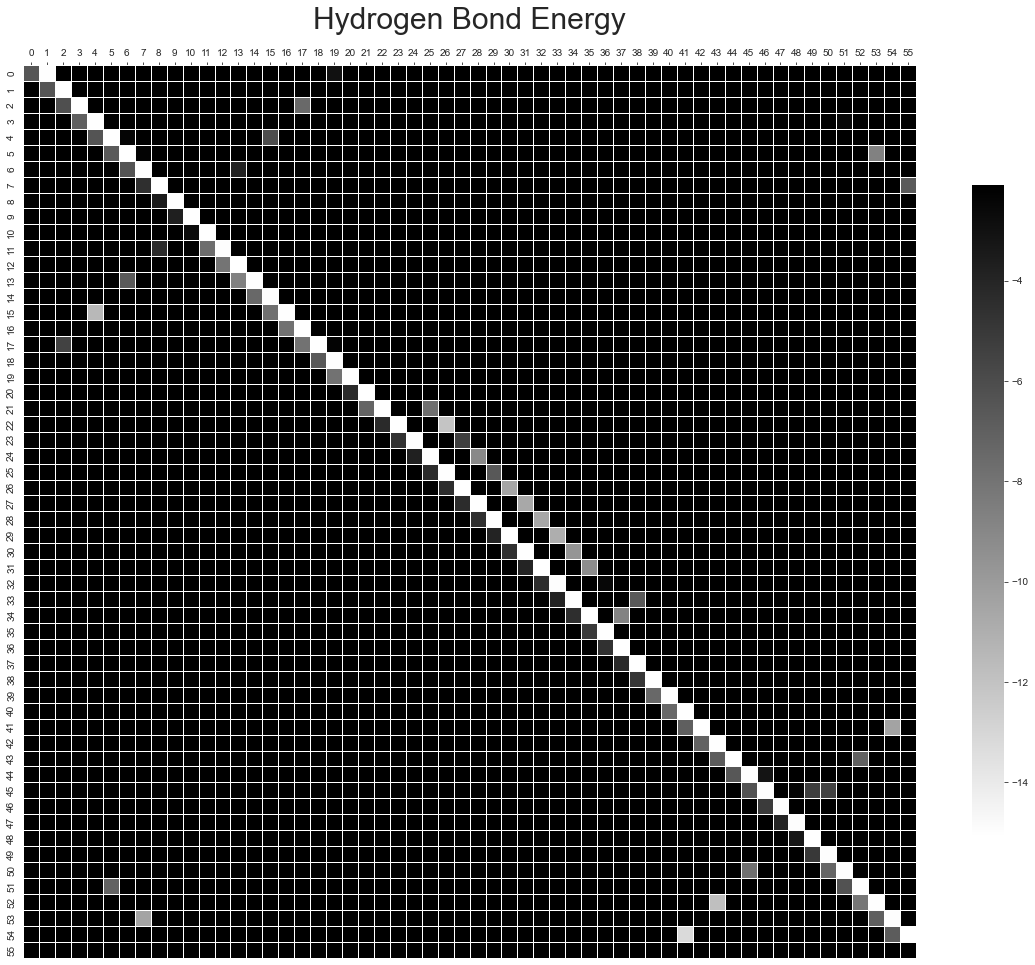

In [9]:
# creating plot
plt.figure()
plt.figure(figsize=(20,20))
im = sns.heatmap(E, vmax=-2.1, cmap="binary", linewidths=0.5, cbar=True, square=True, cbar_kws={"shrink": 0.6})
im.xaxis.tick_top()
im.set_title("Hydrogen Bond Energy", pad=20)
im.title.set_size(30)
cbar_kws={"shrink": 0.6}


#fig.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

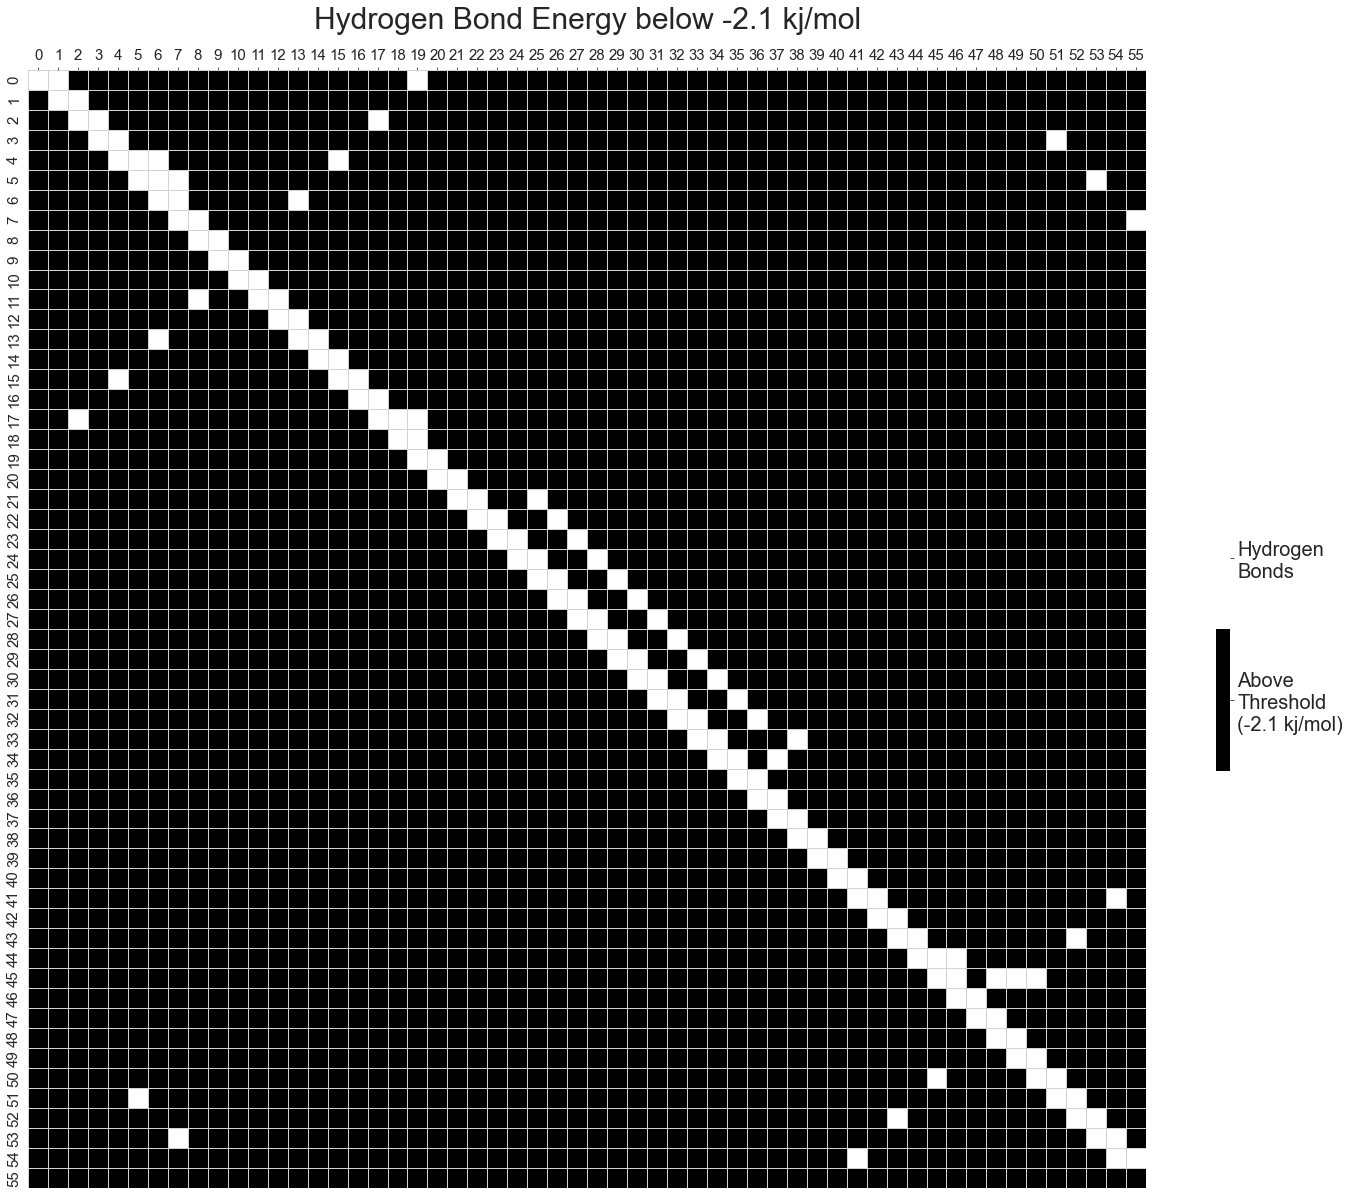

In [32]:
E1 = np.array([[1 if cell <= -2.1 else 0 for cell in row] for row in E])
colors = ((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("custom", colors, len(colors))

# creating plot
plt.figure()

plt.figure(figsize=(20,20))
im = sns.heatmap(E1, cmap=colormap, linewidths=0.5, cbar=True, square=True, center=0.5, linecolor="lightgrey", cbar_kws={"shrink": 0.2})
im.set_title("Hydrogen Bond Energy below -2.1 kj/mol", pad=20)
im.title.set_size(30)
im.xaxis.tick_top()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# setting colorbar ticks
colorbar = im.collections[0].colorbar
colorbar.set_ticks([0.25, 0.75])
colorbar.set_ticklabels(["Above\nThreshold\n(-2.1 kj/mol)", "Hydrogen\nBonds"])
colorbar.ax.tick_params(labelsize=20)

plt.tight_layout()
plt.show()

In [24]:
np.savetxt("resources/dssp_matrix.tsv", E, delimiter="\t")

print(" & ".join([str(i) for i in range(9)]) + " & \\cdots \\\\")
for row in E[:9]:
    print(" & ".join(["{:.2f}".format(value) for value in row[:9]]) + " & \\cdots \\\\")
print(" & ".join(["\\vdots" for i in range(9)]) + "\\\\")

0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & \cdots \\
-6.49 & -15.04 & -1.39 & 0.08 & 0.00 & -0.02 & 0.02 & -0.01 & 0.00 & \cdots \\
0.13 & -6.49 & -15.06 & -1.21 & 0.16 & -0.01 & -0.01 & 0.01 & 0.00 & \cdots \\
-0.06 & 0.13 & -6.16 & -15.06 & -1.75 & 0.20 & -0.05 & 0.01 & -0.02 & \cdots \\
-0.06 & -0.03 & 0.14 & -7.01 & -15.05 & -1.84 & 0.27 & -0.05 & 0.05 & \cdots \\
-0.01 & -0.03 & -0.04 & 0.20 & -6.40 & -15.05 & -2.40 & 0.28 & -0.14 & \cdots \\
-0.01 & 0.01 & -0.02 & -0.10 & 0.05 & -6.69 & -15.06 & -2.29 & 0.41 & \cdots \\
-0.01 & -0.02 & 0.01 & 0.00 & -0.11 & 0.13 & -6.42 & -15.03 & -0.91 & \cdots \\
-0.01 & 0.00 & -0.00 & -0.03 & 0.01 & -0.17 & -0.24 & -4.52 & -15.09 & \cdots \\
-0.00 & -0.01 & 0.01 & -0.01 & 0.00 & 0.04 & -0.11 & 0.63 & -3.45 & \cdots \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots\\
